In [8]:
import os

import numpy as np
import scipy

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import lightning as L

# Load Dataset

In [9]:
data = scipy.io.loadmat('../data/barmovie0113extended.data', squeeze_me=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rep_begin_time', 'rep_end_time', 'PickedCells', 'SpikeTimes', 'peak_times', 'stim'])

One time unit is equivalent to 0.1 milliseconds = `1e-4` seconds

In [10]:
SECONDS_PER_UNIT = 1e-4

Let's plot the full dataset

Text(0.5, 0, 'time (s)')

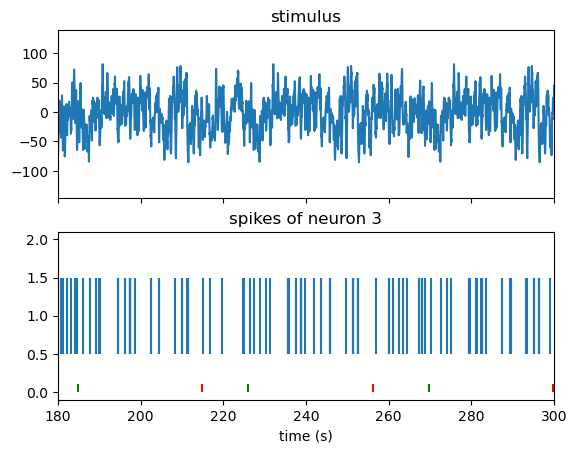

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(data['peak_times'][1:-1] * SECONDS_PER_UNIT, data['stim'])
ax1.set_title('stimulus')

neuron_idx = 3
ax2.set_title(f'spikes of neuron {neuron_idx}')
ax2.eventplot(data['SpikeTimes'][neuron_idx] * SECONDS_PER_UNIT)
ax2.vlines(data['rep_begin_time'] * SECONDS_PER_UNIT, 0, 0.1, color='green')
ax2.vlines(data['rep_end_time'] * SECONDS_PER_UNIT, 0, 0.1, color='red')
ax2.set_xlim(180, 300)
ax2.set_xlabel('time (s)')

In [12]:
torch.log(torch.tensor(0.3))

tensor(-1.2040)

In [13]:
np.log10(SECONDS_PER_UNIT)

np.float64(-4.0)

In [14]:
def positional_embedding(spike_times, dim=8, freq_high = 1/5e-3, freq_low = 1/60):
    t = spike_times.unsqueeze(-1)
    freqs = torch.logspace(torch.tensor(freq_high).log10(), torch.tensor(freq_low).log10(), dim // 2)
    angle_rates = 2 * np.pi * torch.repeat_interleave(freqs, 2).unsqueeze(0)
    angle_rads = t * angle_rates

    # Apply sine to even indices and cosine to odd indices
    embeddings = torch.zeros_like(angle_rads)
    embeddings[:, 0::2] = torch.sin(angle_rads[:, 0::2])
    embeddings[:, 1::2] = torch.cos(angle_rads[:, 1::2])
    
    return embeddings

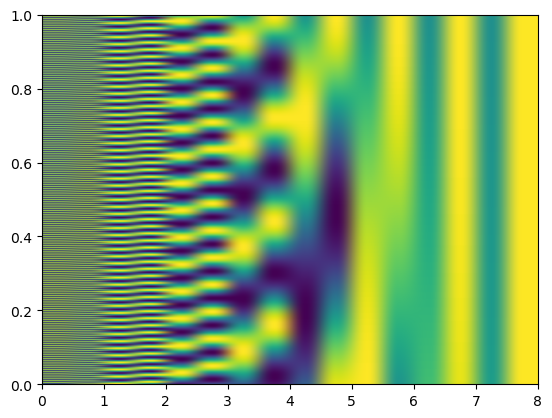

In [15]:
T_max = 1
plt.imshow(positional_embedding(torch.linspace(0, T_max, 1000), 16), aspect='auto', extent=[0, 8, 0, T_max])

Write a Dataset, so we can use the data for ML tasks.

In [152]:
from torch.utils.data import Dataset

class NeuronDataSet(Dataset):
    def __init__(self, filename, neurons = [0], interval = [0.0, 1.0], delta_t = 200):
        super().__init__()
        self.data = scipy.io.loadmat(filename, squeeze_me=True)
        self.neurons = neurons
        self.interval = interval
        self.delta_t = delta_t
        self.stimulus_std = np.std(self.data['stim'])

    def __len__(self):
        return len(self.data['rep_begin_time'])
    
    def __getitem__(self, index):
        t1 = self.data['rep_begin_time'][index]
        t2 = self.data['rep_end_time'][index]
        return self.time_discretized_spikes(*np.interp(self.interval, [0.0, 1.0], [t1, t2]))

    def time_discretized_spikes(self, t_start, t_end):
        grid = torch.arange(t_start, t_end, self.delta_t, dtype=torch.float32)

        peak_times = torch.tensor(self.data['peak_times'][:-2])
        idx = torch.searchsorted(peak_times, grid)
        stimulus = torch.tensor(self.data['stim'][idx] / self.stimulus_std, dtype=torch.float32)

        spikes_binned = []
        spikes_embedded = []
        for k, n in enumerate(self.neurons):
            spike_times = torch.tensor(self.data['SpikeTimes'][n], dtype=torch.float32)
            hist, _ = torch.histogram(spike_times, bins=torch.concat([grid, torch.tensor([t_end], dtype=torch.float32)]))
            spikes_binned.append(hist)
            i_start = torch.searchsorted(spike_times, t_start)
            i_end = torch.searchsorted(spike_times, t_end)
            one_hot = torch.eye(len(self.neurons))[k, :].repeat(i_end - i_start, 1)
            embedding = positional_embedding((spike_times[i_start:i_end] - t_start) * SECONDS_PER_UNIT)
            spikes_embedded.append(torch.cat([one_hot, embedding], dim=-1))

        t_seconds = (grid - t_start) * SECONDS_PER_UNIT
        return t_seconds, stimulus, torch.stack(spikes_binned, dim=-1), torch.cat(spikes_embedded, dim=0)

def collate_time_series(batch):
    # first unzip the batch
    t_batch, s_batch, x_batch, x_embedded = zip(*batch)

    # Find the minimum sequence length
    min_len = min(s.shape[0] for s in s_batch)

    t_truncated = torch.stack([t[:min_len] for t in t_batch], dim=1)
    s_truncated = torch.stack([s[:min_len] for s in s_batch], dim=1)  # (min_len, batch_size, ...)
    x_truncated = torch.stack([x[:min_len] for x in x_batch], dim=1)  # (min_len, batch_size, ...)

    return t_truncated, s_truncated, x_truncated, list(x_embedded)


In [153]:
full_dataset = NeuronDataSet('../data/barmovie0113extended.data', [0])
t, s, x, x_embedded = collate_time_series([b for b in full_dataset])
# t.shape, s.shape, x.shape

Plot one repition of the stimulus

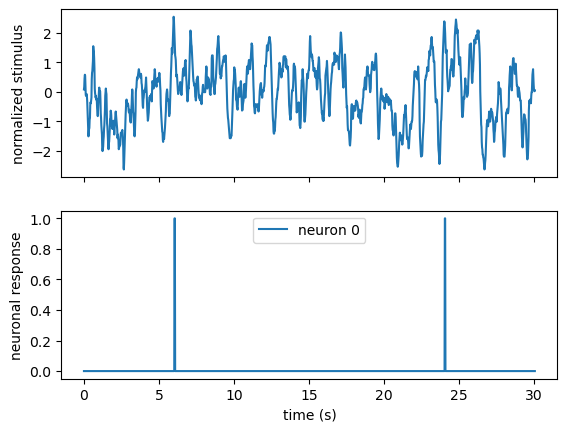

In [154]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(t[:, 0], s[:, 0])
ax1.set_ylabel('normalized stimulus')
for i in range(x.size(2)):
    ax2.plot(t[:, 0], x[:, 0, i], label=f'neuron {i}')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('neuronal response')
ax2.legend()

# Input SDE

## Stochastic Harmonic Oscillator

In [155]:
TAU = 50e-3
DIFFUSION_CONSTANT = 2e3 / 1.13
OMEGA_0 = 9.42

Because the damping coefficient
$$
\gamma = \frac{1}{2 \omega_0 \tau}
$$
is larger than 1, the system is overdamped. However, the system is close to critical damping.

In [156]:
DAMPING_COEFFICIENT = 1.0 / (2 * OMEGA_0 * TAU)
DAMPING_COEFFICIENT

1.0615711252653928

In [157]:
STATIONARY_SIGMA = torch.tensor([1.0, 1/(4*DAMPING_COEFFICIENT**2)])

This defines a stochastically driven harmonic oscillator with variance $\langle x^2 \rangle = 1$.

In [158]:
import torchsde

class StochasticHarmonicOscillator(nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito'

    def __init__(self, damping_coefficient = DAMPING_COEFFICIENT, tau = TAU):
        super().__init__()

        self.A = torch.tensor([[0.0, 1.0],
                               [-1 / (4 * damping_coefficient**2), - 1.0]], dtype=torch.float32) / tau
        
        self.B = torch.tensor([[0.0, 1.0 / (np.sqrt(2.0) * DAMPING_COEFFICIENT)]], dtype=torch.float32) / np.sqrt(tau)

    # Drift
    def f(self, t, y):
        return y @ self.A.T

    # Diffusion
    def g(self, t, y):
        return self.B.expand(y.size(0), 2).unsqueeze(-1)

In [159]:
STATIONARY_SIGMA.shape

torch.Size([2])

In [160]:
y0 = torch.randn(1000, 2) * STATIONARY_SIGMA
model = StochasticHarmonicOscillator()
model.A, model.B

(tensor([[  0.0000,  20.0000],
         [ -4.4368, -20.0000]]),
 tensor([[0.0000, 2.9789]]))

In [162]:
time = t[:, 0]
time

tensor([0.0000e+00, 2.0000e-02, 4.0000e-02,  ..., 3.0020e+01, 3.0040e+01,
        3.0060e+01])

In [163]:
y = torchsde.sdeint(model, y0, time, method='euler', dt=5e-3)

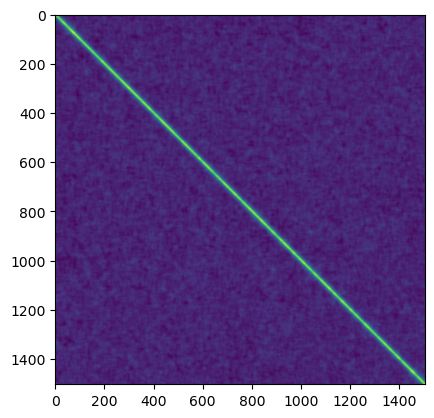

In [170]:
plt.imshow(y[...,0].cov())

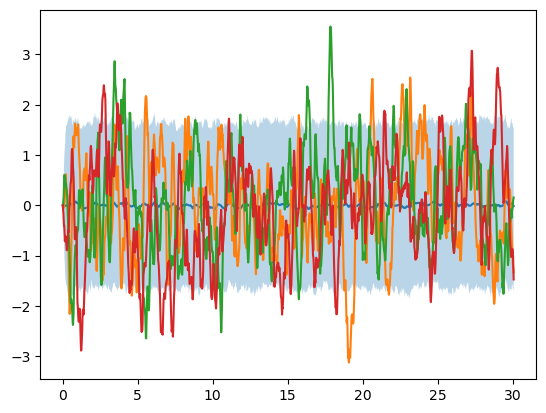

In [42]:
plt.plot(t[:,0], y[:, :, 0].mean(1))
plt.fill_between(t[:,0], y[:, :, 0].quantile(0.05, 1), y[:, :, 0].quantile(0.95, 1), alpha=0.3)
plt.plot(t[:,0], y[:, [0, 1, 2], 0])

In [45]:
test_s = y[:, :, 0]
test_s.shape

torch.Size([1504, 1000])

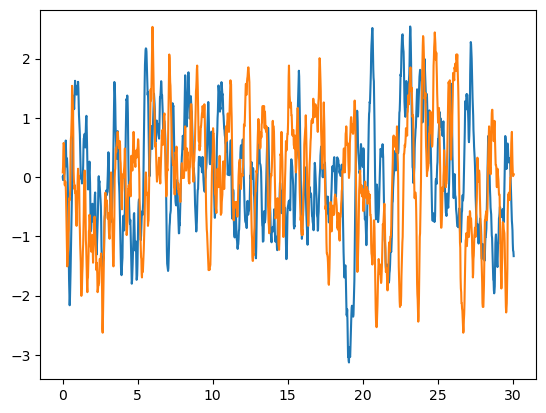

In [46]:
plt.plot(t[:,0], test_s[:, 0])
plt.plot(t[:,0], s[:, 0])

## Gaussian Process

In [ ]:
class StochasticHarmonicOscillatorKernel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, t1, t2):
        t = (t2 - t1).abs() / TAU
        i_omega = np.sqrt(0.25 - 1/(4 * DAMPING_COEFFICIENT**2))
        pos = torch.exp((i_omega - 0.5) * t)
        neg = torch.exp((-i_omega - 0.5) * t)
        c = 0.5 * (pos + neg)
        s = 0.5 * (pos - neg)
        return c + 0.5 * s / i_omega

In [246]:
class GProcess(nn.Module):
    def __init__(self, kernel, t_obs, x_obs, sigma):
        super().__init__()
        self.kernel = kernel

        K = kernel(t_obs, t_obs.unsqueeze(1))
        self.L = torch.linalg.cholesky(K + sigma * torch.eye(t_obs.size(0)))
        self.alpha = torch.cholesky_solve(x_obs.unsqueeze(1), self.L)
        self.t_obs = t_obs

    def forward(self, t):
        k_test_train = self.kernel(t, self.t_obs.unsqueeze(1))
        mean = (k_test_train.T @ self.alpha).squeeze(1)
        v = torch.linalg.solve_triangular(self.L, k_test_train, upper=False)
        cov = self.kernel(t, t.unsqueeze(1)) - v.T @ v
        return torch.distributions.MultivariateNormal(mean, cov)
    
    def prior(self, t):
        mean = torch.zeros_like(t)
        cov = self.kernel(t, t.unsqueeze(1))
        return torch.distributions.MultivariateNormal(mean, cov)

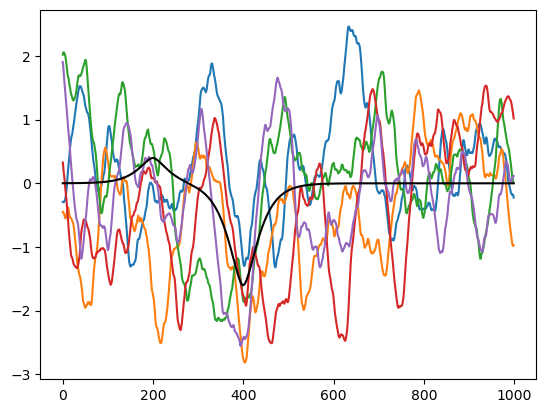

In [253]:
kernel = StochasticHarmonicOscillatorKernel()
gaussian_process = GProcess(kernel, torch.tensor([1.0, 2.0]), torch.tensor([1.0, -4.0]), torch.tensor(1.5))

prior = gaussian_process.prior(torch.linspace(0, 5, 1000))
post = gaussian_process(torch.linspace(0, 5, 1000))
plt.plot(post.sample((5,)).T)
plt.plot(post.mean, color='black')
# plt.plot(time, gaussian_process(time).sample((1,)).T)
# plt.plot(time, s[:, 0])

In [254]:
torch.distributions.kl_divergence(post, prior)

tensor(1.6595)

# ML Models

In [109]:
class ConditionalSpikeRNN(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        # RNN layer (stimulus dimension is 1)
        self.rnn = nn.GRU(1 + n_neurons, hidden_size, num_layers, batch_first=False, dropout=0.3)
        self.h_0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

        # Linear layer to output spike prob for each neuron
        self.output_layer = nn.Linear(hidden_size, n_neurons)

    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.unsqueeze(-1)

        # shift right
        x = x.roll(1, 0)  # (seq_len, batch_size, n_neurons)
        x[0, :, :] = 0.0

        # Expand h_0 to match batch size
        h_0 = self.h_0.expand(-1, batch_size, -1).contiguous()

        # Forward through RNN
        rnn_out, _ = self.rnn(torch.cat([s, x], dim=2), h_0)

        output = self.output_layer(rnn_out)  # (seq_len, batch_size, n_neurons)

        # returns the logits
        return output

In [247]:
from torch.distributions.poisson import Poisson

In [248]:
class ConditionalSpikeCNN(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=10):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        layers = []
        for i in range(num_layers):
            in_size = 1 if i == 0 else hidden_size
            layers.append(nn.Conv1d(in_size, hidden_size, kernel_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())

        self.conv_net = nn.Sequential(
            nn.ZeroPad1d(((kernel_size - 1) * num_layers, 0)), # needed for causality
            *layers,
            # 1x1 convolution layer to output spike intensity for each neuron
            nn.Conv1d(hidden_size, n_neurons, 1)
        )


    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.transpose(0, 1).unsqueeze(1) # (batch_size, 1, seq_len)
        else:
            raise ValueError(f"Wrong shape of s: {s.shape}")

        # # shift right
        # x = x.roll(1, 0)  # (seq_len, batch_size, n_neurons)
        # x[0, :, :] = 0.0

        # output = self.conv_net(torch.cat([s, x.permute((1, 2, 0))], dim=1)) # (batch_size, n_neurons, seq_len)
        output = self.conv_net(s) # (batch_size, n_neurons, seq_len)
        
        # returns the intensities (seq_len, batch_size, n_neurons)
        return output.permute((2, 0, 1))
    
    def sampler(self, s: torch.Tensor):
        seq_len, batch_size = s.size()
        log_intensities = self(s, torch.empty((seq_len, batch_size, self.n_neurons)))
        return Poisson(log_intensities.exp())


We train using the poisson negative log likelihood loss function. The Poisson likelihood of a process with intensity $\lambda$ is given by
$$
\mathrm{P}(N(t) = n) = \frac{(\lambda t)^n}{n!} e^{-\lambda t} \,.
$$
If we time-discretize our spikes with time-interval $\Delta t$ and the poisson intensity at time $t_i = i \Delta t$ is given by $\lambda_i$, then the probability of observing $n_i$ spikes in the time-interval $[t_i, t_{i+1})$ is given by
$$
\mathrm{P}(N_i = n_i) = \frac{(\lambda_i \Delta t)^{n_i}}{n_i !} e^{-\lambda_i \Delta t} \,.
$$
Therefore, the negative log likelihood is given by
$$
\mathcal{L} = - \sum_i \ln\mathrm{P}(N_i = n_i) = \sum_i - n_i \ln \lambda_i \Delta t + \lambda_i \Delta t + \ln(n_i !)
$$

In [249]:
class SpikeModel(L.LightningModule):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=None, model_type='RNN'):
        super().__init__()
        self.save_hyperparameters()
        if model_type == 'RNN':
            if kernel_size is not None:
                raise ValueError('cannot set kernel size for RNN.')
            self.net = ConditionalSpikeRNN(n_neurons, hidden_size, num_layers)
        elif model_type == 'CNN':
            self.net = ConditionalSpikeCNN(n_neurons, hidden_size, num_layers, kernel_size=kernel_size)
        else:
            raise ValueError(f"unsupported model type {model_type}")
        self.loss_fn = nn.PoissonNLLLoss(log_input=True)

    def training_step(self, batch, batch_idx):
        t, s, x, _ = batch
        
        log_intensity = self.net(s, x)

        # alpha = np.sin(0.5 * np.pi * min(1.0, self.global_step / (self.trainer.estimated_stepping_batches * 0.6)))
        # train_loss = (1 - alpha) * self.loss_fn(log_intensity, x) + alpha * nn.functional.binary_cross_entropy_with_logits(logits, x)
        
        train_loss = self.loss_fn(log_intensity, x)
        self.log("train_loss", train_loss, prog_bar=True, on_epoch=True, batch_size=x.size(1))
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        t, s, x, _ = batch
        x = torch.clamp(x, 0, 1)
        log_intensity = self.net(s, x)

        val_loss = self.loss_fn(log_intensity, x)
        
        # Log validation loss
        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True, batch_size=x.size(1))
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, total_steps=total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

# Training

In [250]:
neurons = data['PickedCells'][:18]
train_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, [0.0, 0.7])
validation_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, [0.7, 1.0])
train_dataset[0][0].shape, validation_dataset[0][0].shape

(torch.Size([1053]), torch.Size([452]))

In [251]:
t_train, s_train, x_train, x_emb_train = collate_time_series([v for v in train_dataset])
pos_weights = torch.clamp(x_train.shape[0] * x_train.shape[1] / x_train.sum(dim=[0, 1]), 0, 10e3)
pos_weights
x_train.max()

tensor(6.)

In [252]:
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_time_series)
val_loader = DataLoader(validation_dataset, batch_size=126, collate_fn=collate_time_series)

spike_model = SpikeModel(len(neurons), 16, 2, model_type='CNN', kernel_size=10)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",    # Directory to save checkpoints
    filename="{epoch:02d}",  # File name format
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=5,  # Save every N epochs
)

lr_monitor = LearningRateMonitor(logging_interval='step')

# trainer = L.Trainer(max_epochs=150, callbacks=[checkpoint_callback])
trainer = L.Trainer(max_epochs=30, callbacks=[lr_monitor], log_every_n_steps=5)
trainer.fit(model=spike_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.
/data/clusterusers/reinhardt/miniconda3/envs/ml-pws/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | net     | ConditionalSpikeCNN | 3.1 K  | train
1 | loss_fn | PoissonNLLLoss      | 0      | train
--------------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/clusterusers/reinhardt/miniconda3/envs/ml-pws/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [253]:
def plot_network_performance(model, train_dataset, validation_dataset, out_path=None):
    t_train, s_train, x_train, _ = collate_time_series([v for v in train_dataset])
    t_val, s_val, x_val, _ = collate_time_series([v for v in validation_dataset])
    model.net.eval()

    fig, axs = plt.subplots(1 + model.net.n_neurons, 2, width_ratios=[0.7, 0.3], constrained_layout=True)

    for ax, t, s, title in zip(axs[0, :], [t_train, t_val], [s_train, s_val], ["training", "validation"]):
        ax.plot(t[:, 0], s.mean(1))
        ax.set_title(title)


    for j, t, s, x in zip([0, 1], [t_train, t_val], [s_train, s_val], [x_train, x_val]):
        with torch.no_grad():
            log_intensity = model.net(s, x)

        intensity = log_intensity.exp().mean(1)
        for i in range(model.net.n_neurons):
            ax = axs[i+1, j]
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_ylim(-0.2, 0.2)
            ax.plot(t[:, 0], intensity[:, i], linewidth=1)
            ax.plot(t[:, 0], -x[:, :, i].mean(1), linewidth=1)

    if out_path is not None:
        fig.savefig(out_path)
    return fig

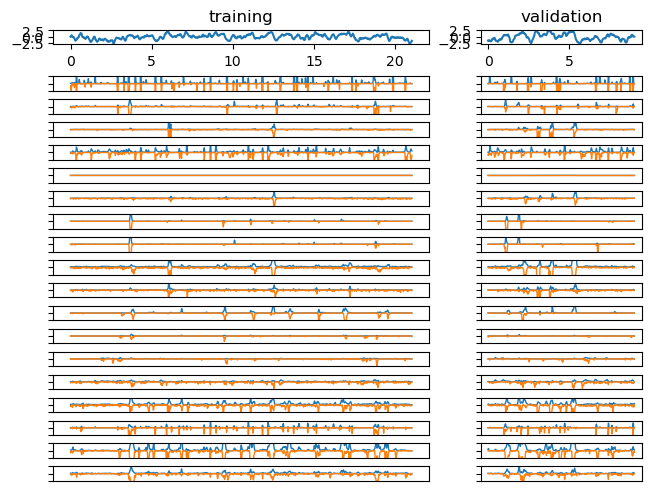

In [254]:
plot_network_performance(spike_model, train_dataset, validation_dataset);

In [70]:
CKPT_PATH = "checkpoints"

for ckpt in os.listdir(CKPT_PATH):
    model = SpikeModel.load_from_checkpoint(os.path.join(CKPT_PATH, ckpt), n_neurons=len(neurons), hidden_size=64, num_layers=2, pos_weights=pos_weights)
    filename, _ = os.path.splitext(ckpt)
    plot_network_performance(model, train_dataset, validation_dataset, out_path=f"../reports/{filename}.png")

RuntimeError: Error(s) in loading state_dict for SpikeModel:
	size mismatch for net.rnn.weight_ih_l0: copying a param with shape torch.Size([192, 4]) from checkpoint, the shape in current model is torch.Size([192, 19]).
	size mismatch for net.output_layer.weight: copying a param with shape torch.Size([3, 64]) from checkpoint, the shape in current model is torch.Size([18, 64]).
	size mismatch for net.output_layer.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for loss_fn.pos_weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([18]).

# PWS Estimate

In [452]:
t_val, s_val, x_val, x_emb = collate_time_series([v for v in validation_dataset])
x_val.shape

torch.Size([452, 136, 18])

In [477]:
def log_probability(model, s, x):
    model.eval()
    log_intensity = model(s, x)
    return -nn.functional.poisson_nll_loss(log_intensity, x, log_input=True, full=True, reduction='none')

In [454]:
stoch_osc = StochasticHarmonicOscillator()
y0 = torch.zeros(10000, 2)
y = torchsde.sdeint(stoch_osc, y0, t_val[:,0], dt=1/60)
s_samples = y[:, :, 0]
s_samples.shape

torch.Size([452, 10000])

In [455]:
i = 1
x_expanded = x_val[:, [i]].expand(-1, s_samples.size(1), -1)

with torch.no_grad():
    logp_conditional = log_probability(spike_model.net, s_val[:, [i]], x_val[:, [i]])
    logp_marginal = log_probability(spike_model.net, s_samples, x_expanded)

dkl = logp_conditional - logp_marginal
dkl.shape

torch.Size([452, 10000])

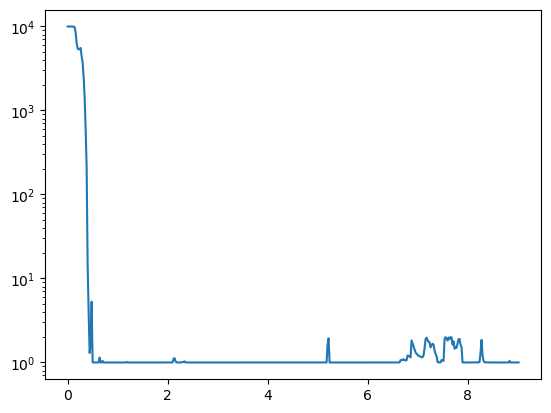

In [456]:
plt.plot(t_val[:, 0], 1 / (nn.functional.softmax(dkl.cumsum(0), 1) ** 2).sum(1))

plt.yscale('log')

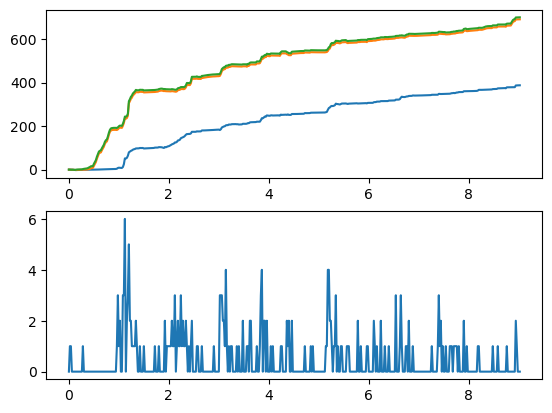

In [457]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_val[:, 0], dkl.cumsum(0).mean(1))
ax1.plot(t_val[:, 0], dkl.cumsum(0).logsumexp(1) - np.log(dkl.size(1)))
ax1.plot(t_val[:, 0], dkl.cumsum(0).max(1)[0])

ax2.plot(t_val[:, 0], x_val[:, [i]].sum(-1))

In [458]:

def smoothed_mi(dkl_T: torch.tensor, kernel_size: int, n_bootstrap: int = 500):
    kernel = torch.ones(1, 1, kernel_size)

    # (batch_size, length - kernel_size)
    smoothed = nn.functional.conv1d(dkl_T, kernel).squeeze(1)

    ess = (1 / (nn.functional.softmax(smoothed, 0) ** 2).sum(0)).mean()

    n = smoothed.size(0)
    indices = torch.randint(0, n, (n_bootstrap,n))

    x = smoothed[indices.flatten(), :].unflatten(0, (n_bootstrap, n))

    return torch.mean(x.logsumexp(1) - np.log(n), dim=-1), ess



def bootstrap_mi_estimate(dkl, length, n_bootstrap = 512):
    mi = torch.empty((len(length), n_bootstrap))
    ess = torch.empty(len(length))

    # (batch_size, 1, length)
    dkl_T = dkl.T.contiguous().unsqueeze(1)

    for i, kernel_size in enumerate(length):
        mi_i, ess_i = smoothed_mi(dkl_T, kernel_size, n_bootstrap)
        mi[i] = mi_i
        ess[i] = ess_i
    return mi, ess
        

length = range(1, 400, 25)
mi, ess = bootstrap_mi_estimate(dkl, length)

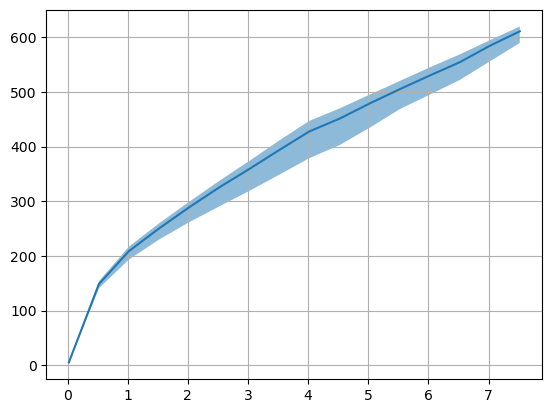

In [460]:
upper = torch.quantile(mi, 0.95, dim=1)
lower = torch.quantile(mi, 0.05, dim=1)
plt.fill_between(t_val[length, 0], lower, upper, alpha=0.5)
plt.plot(t_val[length, 0], torch.mean(mi, dim=1))
plt.grid()

(0.0, 10000.0)

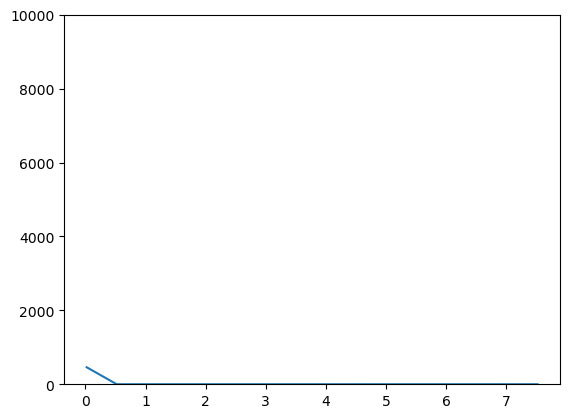

In [263]:
plt.plot(t_val[length, 0], ess)
plt.ylim(0, 1e4)

# Variational PWS

### Encoder

Now create a variational SDE model

In [416]:
class SimpleEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 64, bins=torch.linspace(0.0, 10.0, 126)):
        super().__init__()
        input_dim = bins.size(0) + 2
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        self.output_layer = nn.Linear(input_dim, 1)
        self.bins = bins

    def forward(self, t, y, _context):
        dt = self.bins - t
        t_emb = torch.exp(-0.5 * dt**2 / 0.1**2).expand(y.size(0), -1) # (N, d_emb)
        x = torch.cat([y, t_emb], dim=-1) # (N, d)

        x = self.net(x) + x
        return self.output_layer(x).squeeze(-1)

In [417]:
class VariationalEncoder(nn.Module):
    def __init__(self, query_dim: int, feature_dim: int, hidden_dim: int = 512, n_heads=8):
        super().__init__()

        self.nheads = n_heads
        self.E_head = hidden_dim // n_heads

        self.q_proj = nn.Linear(query_dim, hidden_dim)
        self.k_proj = nn.Linear(feature_dim, hidden_dim)
        self.v_proj = nn.Linear(feature_dim, hidden_dim)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, t, y, context):
        t_emb = positional_embedding(t).expand(y.size(0), -1)
        query = torch.cat([y, t_emb], dim=-1).unsqueeze(1) # (N, L=1, signal_dim)
        context = context.unsqueeze(0) # (N, num_spikes, feature_dim)
        
        # (N, L_t, hidden_dim) -> (N, L_t, nheads, E_head) -> (N, nheads, L_t, E_head)
        query = self.q_proj(query).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        key = self.k_proj(context).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        value = self.v_proj(context).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)

        # (N, nheads, L=1, E_head)
        x = nn.functional.scaled_dot_product_attention(query, key, value)
        x = x + query # residual connection

        # (N, L=1, hidden_dim)
        x = x.transpose(1, 2).flatten(-2)

        return self.feedforward(x).squeeze((-2, -1))

In [418]:
batch_size = 25
num_spikes = 7
feature_dim = 13
# var_enc = VariationalEncoder(8 + 2, feature_dim)
var_enc = SimpleEncoder()
var_enc(torch.tensor(0.5), torch.rand(batch_size, 2), torch.rand(7, feature_dim))

tensor([0.1917, 0.2219, 0.2304, 0.2634, 0.2300, 0.2703, 0.2463, 0.2389, 0.2292,
        0.1932, 0.1988, 0.2942, 0.2570, 0.1901, 0.2897, 0.2419, 0.2623, 0.2477,
        0.2424, 0.2421, 0.2493, 0.2410, 0.2583, 0.2609, 0.2761],
       grad_fn=<SqueezeBackward1>)

In [419]:
torch.exp(-0.5 * (var_enc.bins - torch.tensor(0.5))**2 / 0.1**2).shape

torch.Size([126])

In [420]:
class VariationalSDE(nn.Module):
    def __init__(self, base_model: nn.Module, encoder: nn.Module, context: torch.tensor):
        super().__init__()
        self.context = context
        self.base_model = base_model

        self.noise_type = base_model.noise_type
        self.sde_type = base_model.sde_type

        self.encoder = encoder

    # Drift
    def f(self, t, y):
        drift = self.base_model.f(t, y)
        drift[:, 1] += self.encoder(t, y, self.context)
        return drift

    # Diffusion
    def g(self, t, y):
        return self.base_model.g(t, y)

    # Base measure
    def h(self, t, y):
        return self.base_model.f(t, y)

In [ ]:
class VariationalConditionalSDE(nn.Module):
    def __init__(self, n_neurons, sde_dt = 1/60):
        super().__init__()

        self.prior_sde = StochasticHarmonicOscillator()
        # self.encoder = VariationalEncoder(2 + 8, n_neurons + 8, n_neurons * 8)
        self.encoder = SimpleEncoder(128)

        self.sde_dt = sde_dt

    def forward(self, t: torch.tensor, x_emb: torch.tensor, batch_size: int = 1):
        sde = VariationalSDE(self.prior_sde, self.encoder, x_emb)
        y0 = torch.zeros((batch_size, 2))
        y, logqp = torchsde.sdeint(sde, y0, t, method='euler', dt=self.sde_dt, logqp=True)
        return y[...,0], logqp.sum(0).mean()
        

### Lightning Module

In [ ]:
class VariationalModel(L.LightningModule):
    def __init__(self, forward_model, backward_model, variational_samples=128):
        super().__init__()
        self.forward_model = forward_model
        self.backward_model = backward_model

        self.forward_model.eval()
        self.forward_model.requires_grad_(False)

        self.variational_samples = variational_samples
        
    def training_step(self, batch, batch_idx):
        t, s, x, x_emb = batch

        assert len(x_emb) == 1

        t = t[:, 0].contiguous()
        x_emb = x_emb[0]
        
        s, kl_div = self.backward_model(t, x_emb, self.variational_samples)

        x_expanded = x.expand(-1, self.variational_samples, -1)
        logp_forward = log_probability(self.forward_model, s, x_expanded).sum((0,-1)).mean()

        self.log("kl_div", kl_div)
        self.log("logp", logp_forward)

        # ELBO
        train_loss = -(logp_forward - kl_div)

        self.log("train_loss", train_loss)
        return train_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=1e-1)
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-1, total_steps=total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

In [516]:
test_t, test_s, test_x, test_x_emb = validation_dataset[0]

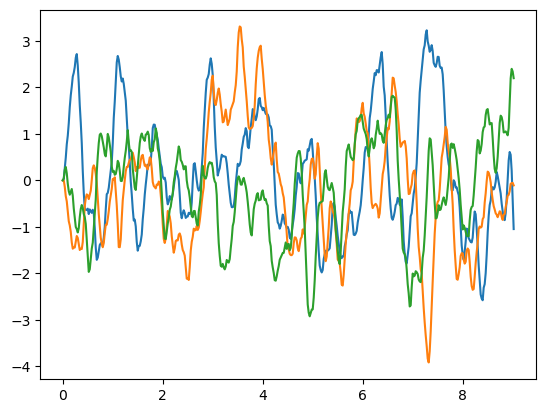

In [517]:
stoch_osc = StochasticHarmonicOscillator(50e-3, 1e3, 9.42)
backward_model = VariationalConditionalSDE(len(neurons))
s, logqs = backward_model(test_t, test_x_emb, 3)
plt.plot(test_t, s.detach())

In [518]:
forward_model = spike_model.net
variational_model = VariationalModel(forward_model, backward_model)
variational_model

VariationalModel(
  (forward_model): ConditionalSpikeCNN(
    (conv_net): Sequential(
      (0): ZeroPad1d((18, 0))
      (1): Conv1d(1, 16, kernel_size=(10,), stride=(1,))
      (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(10,), stride=(1,))
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv1d(16, 18, kernel_size=(1,), stride=(1,))
    )
  )
  (backward_model): VariationalConditionalSDE(
    (prior_sde): StochasticHarmonicOscillator()
    (encoder): SimpleEncoder(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (output_layer): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [519]:
trainer = L.Trainer(max_steps=136, log_every_n_steps=1)
trainer.fit(model=variational_model, train_dataloaders=DataLoader(validation_dataset, collate_fn=collate_time_series))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name           | Type                      | Params | Mode 
---------------------------------------------------------------------
0 | forward_model  | ConditionalSpikeCNN       | 3.1 K  | eval 
1 | backward_model | VariationalConditionalSDE | 33.2 K | train
---------------------------------------------------------------------
33.2 K    Trainable params
3.1 K     Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)
8         Modules in train mode
10        Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=136` reached.


In [520]:
test_t, test_s, test_x, test_x_emb = validation_dataset[0]

In [521]:
with torch.no_grad():
    posterior_samples, kl_div = variational_model.backward_model(test_t, test_x_emb, 4096)

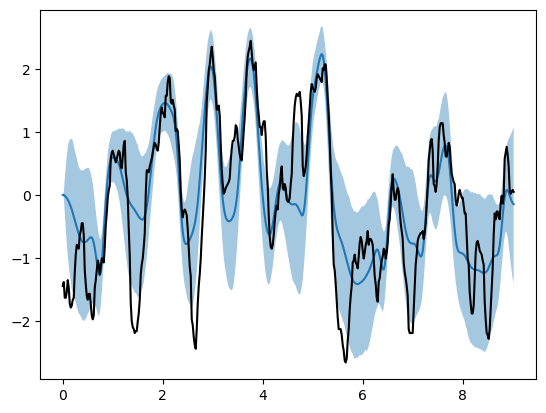

In [522]:
plt.plot(test_t, posterior_samples.mean(1))
# plt.plot(test_t, posterior_samples[:, [0]])
plt.fill_between(test_t, *posterior_samples.quantile(torch.tensor([0.05, 0.95]), dim=1), alpha=0.4)
plt.plot(test_t, test_s, color='black')
# plt.plot(test_t, test_x)

In [532]:
logp_forward = log_probability(spike_model.net, posterior_samples, test_x.unsqueeze(1)).sum(-1)
logp_forward.shape, kl_div.shape # (length, samples)

(torch.Size([452, 4096]), torch.Size([451, 4096]))

In [533]:
log_marginal = logp_forward[1:] - kl_div
log_conditional = log_probability(spike_model.net, test_s.unsqueeze(1), test_x.unsqueeze(1)).sum(-1)
dkl = log_conditional[1:] - log_marginal
dkl.size()

torch.Size([451, 4096])

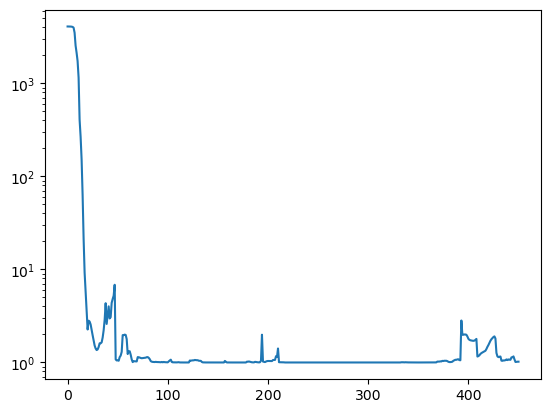

In [534]:
ess = (1 / (nn.functional.softmax(dkl.cumsum(0), 1) ** 2).sum(1))
plt.plot(ess)
plt.yscale('log')

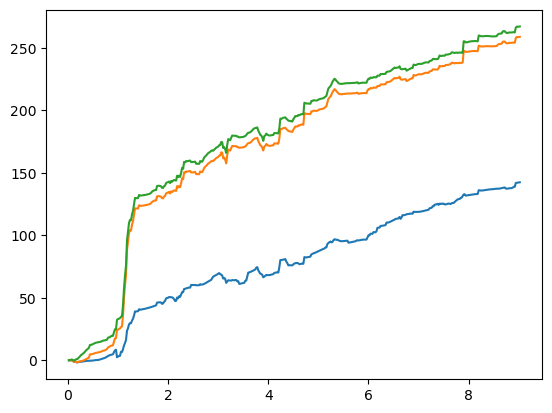

In [535]:
plt.plot(test_t[1:], dkl.cumsum(0).mean(1))
plt.plot(test_t[1:], dkl.cumsum(0).logsumexp(1) - np.log(dkl.size(1)))
plt.plot(test_t[1:], dkl.cumsum(0).max(1)[0])

In [536]:
length = range(1, 400, 25)
mi, ess = bootstrap_mi_estimate(dkl, length, n_bootstrap=512)

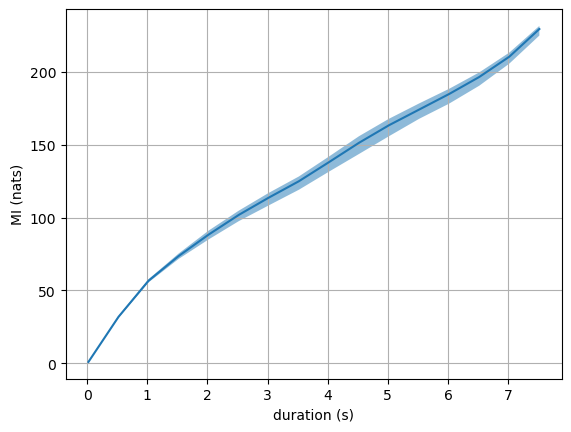

In [537]:
upper = torch.quantile(mi, 0.95, dim=1)
lower = torch.quantile(mi, 0.05, dim=1)
plt.fill_between(t_val[length, 0], lower, upper, alpha=0.5)
plt.plot(t_val[length, 0], torch.mean(mi, dim=1))
plt.xlabel('duration (s)')
plt.ylabel('MI (nats)')
plt.grid()

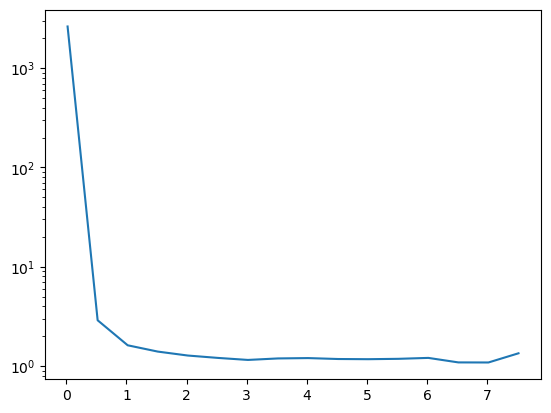

In [538]:
plt.plot(t_val[length, 0], ess)
plt.yscale('log')